In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import numpy as np
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten

#model1

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    layer.trainable = False

# Add new layers to the ResNet50 model
x1 = resnet_model.output
x1 = Flatten()(x1)
x1 = Dense(50, activation='relu')(x1)
x1 = Dense(50, activation='relu')(x1)
predictions1 = Dense(5, activation='softmax')(x1)

model1 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions1)
model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
class CustomMatrixMetric(tf.keras.metrics.Metric):
    def __init__(self, name='custom_matrix_metric', **kwargs):
        super(CustomMatrixMetric, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=-1)
        y_true_classes = tf.argmax(y_true, axis=-1)
        distant = tf.cast(tf.abs(y_pred_classes - y_true_classes), dtype=tf.float32)
        matrix = 1 - tf.math.pow(distant / 4, 2)
        value = tf.reduce_sum(matrix)
        count = tf.cast(tf.size(y_true_classes), dtype=tf.float32)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, dtype=tf.float32)
            sample_weight = tf.broadcast_to(sample_weight, shape=y_true_classes.shape)
            count = tf.reduce_sum(sample_weight)
            value = tf.reduce_sum(matrix * sample_weight)
        self.total.assign_add(value)
        self.count.assign_add(count)
    
    def result(self):
        return self.total / self.count
    
    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)


In [95]:
#model1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a preprocessing function to apply to images
def custom_preprocessing(image):
    # padding -> down-sampling -> 
    
    # Apply per-image standardization
    height,width = image.shape[0:2]
    n=0;m=0
    if height > width:
        m = abs(height-width)//2
    else:
        n= abs(height-width)//2

    paddings = tf.constant([[n, n], [m, m],[0,0]]) 
    image = tf.pad(image, paddings, mode='CONSTANT')
    new_size = (224, 224)
    image = tf.image.resize(image, new_size, method='bilinear')
    image = tf.image.per_image_standardization(image)
    return image


# Define data generators for training and validation sets
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    validation_split=0.2,
    rotation_range=20,        # random rotation up to 20 degrees
   # width_shift_range=0.1,    # random horizontal shift up to 10%
   # height_shift_range=0.1,   # random vertical shift up to 10%
   #3 shear_range=0.1,          # random shearing up to 10%
    zoom_range=0.1,           # random zoom up to 10%
    horizontal_flip=True,     # random horizontal flip
 
)


# Define paths to the training and validation sets
train_dir = 'Train/TrainG/'

# Set the batch size and image dimensions
batch_size = 10
img_height = 224
img_width = 224

# Create data generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
)

# Compile and train the model using the data generators
model1.compile(optimizer= 'adam' , loss='categorical_crossentropy', metrics=['accuracy',CustomMatrixMetric()])
history = model1.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight={0: 0.5, 1: 3, 2: 1.0, 3: 3, 4: 3.5}
)

Found 3369 images belonging to 5 classes.
Found 840 images belonging to 5 classes.
Epoch 1/30
337/337 [==============================] - ETA: 0s - loss: 1.8409 - accuracy: 0.4892 - custom_matrix_metric: 0.8808

UnknownError: 2 root error(s) found.
  (0) Unknown:  FileNotFoundError: [Errno 2] No such file or directory: 'Train/Train/0\\Train_100.jpg'
Traceback (most recent call last):

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 839, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 965, in generator_fn
    yield x[i]

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\keras_preprocessing\image\utils.py", line 113, in load_img
    with open(path, 'rb') as f:

FileNotFoundError: [Errno 2] No such file or directory: 'Train/Train/0\\Train_100.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
  (1) Unknown:  FileNotFoundError: [Errno 2] No such file or directory: 'Train/Train/0\\Train_100.jpg'
Traceback (most recent call last):

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\ops\script_ops.py", line 249, in __call__
    ret = func(*args)

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 892, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 839, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py", line 965, in generator_fn
    yield x[i]

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "C:\Users\latte\anaconda3\envs\w1\lib\site-packages\keras_preprocessing\image\utils.py", line 113, in load_img
    with open(path, 'rb') as f:

FileNotFoundError: [Errno 2] No such file or directory: 'Train/Train/0\\Train_100.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_7048910]

Function call stack:
test_function -> test_function


In [32]:
train

,id_code,diagnosis
0,Train_1,2
1,Train_2,2
2,Train_3,4
3,Train_4,2
4,Train_5,3
...,...,...
4204,Train_4205,2
4205,Train_4206,2
4206,Train_4207,2
4207,Train_4208,0


In [94]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
correct=np.zeros(5)
miss=np.zeros(5)
for i in range(4209):
    path=('Train/TrainG/Train_')
    img = load_img(path+str(i+1)+'.jpg', target_size=(224, 224))
    img = np.array(img)
    img = custom_preprocessing(img)
    y=np.argmax(model1.predict(img[None,:,:,:]))
    if(y == train['diagnosis'][i]):
        correct[y]+=1
    else:
        miss[y]+=1

FileNotFoundError: [Errno 2] No such file or directory: 'Train/TrainG/Train_1.jpg'

In [65]:
Ypredict=pd.read_csv('Sample_Submission.csv')
for i in range(1968):
    path=('Train/TrainG/Train_')
    img = load_img(path+str(i+1)+'.jpg', target_size=(224, 224))
    img = np.array(img)
    img = custom_preprocessing(img)
    y=np.argmax(model1.predict(img[None,:,:,:]))
    Ypredict.loc[i,'diagnosis']=y.copy()

In [73]:
Ypredict.to_csv('prediction2.csv',index=False)

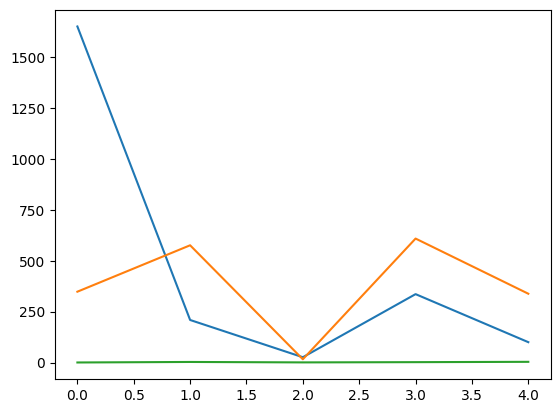

In [62]:
plt.plot(correct)
plt.plot(miss)


In [72]:
sum(miss)

1887.0

In [101]:
Ypredict['diagnosis']=Ypredict['diagnosis'].astype('int32')

In [84]:
x1=pd.read_csv('prediction1.csv')
x2=pd.read_csv('prediction2.csv')

In [102]:
Ypredict.to_csv('prediction2.csv',index=False)